In [5]:
import pickle
import keras
import tensorflow as tf
#from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import decomposition
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

ImportError: cannot import name 'get_model_lstm_conv2d'

In [2]:
full_pca_fitter={}
delta_pca_fitter={}
kernels = {}

In [6]:
full_data_path = '/scratch/gpfs/jabbate/old_stuff/new_data/directory.pkl'
with open(full_data_path,'rb') as f:
    directory=pickle.load(f, encoding='latin1')


In [58]:
# full_data_path = '/scratch/gpfs/jabbate/old_stuff/new_data/final_data.pkl'
full_data_path = '/scratch/gpfs/jabbate/full_data/train_data.pkl'

test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
# profiles = ['thomson_temp_EFITRT1','thomson_dens_EFITRT1','temp','dens']
profiles = ['temp','dens','rotation','itemp','idens']
# for profile in tqdm(profiles):
traindata, valdata, normalization_dict = helpers.data_generator.process_data(full_data_path,
                                                      profiles,
                                                      normalization_method='RobustScaler',
                                                      window_length=1,
                                                      window_overlap=0,
                                                      lookbacks=0,
                                                      lookahead=0,
                                                      sample_step=1,
                                                      uniform_normalization=True,
                                                      train_frac=1,
                                                      val_frac=0,
                                                      nshots=10000,
                                                      verbose=2,
                                                      flattop_only=True,
                                                      randomize=False,
                                                      pruning_functions=['remove_nan',
                                                                         'remove_dudtrip',
                                                                         'remove_I_coil',
                                                                         'remove_non_gas_feedback',
                                                                         'remove_ECH'],
                                                      excluded_shots=['topology_TOP', 
                                                                      'topology_OUT',
                                                                      'topology_MAR',
                                                                      'topology_IN',
                                                                      'topology_DN',
                                                                      'topology_BOT'],
                                                      delta_sigs=[])


Loading
Signals: dens, idens, itemp, rotation, temp
Number of useable shots:  5444
Number of shots used:  5444
Total number of timesteps:  573222
Shots with Complete NaN: 
395041 samples total
Removing ECH
Removed 144098 samples
250943 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 40921 samples
210022 samples remaining
Removing weird I-coils
Removed 40140 samples
169882 samples remaining
Removing NaN
Removed 0 samples
169882 samples remaining
Removing dudtrip
Removed 5132 samples
164750 samples remaining
164750 samples remaining after pruning
Total number of samples:  164750
Number of training samples:  164750
Number of validation samples:  0


In [61]:
X = np.concatenate([traindata[profile][::50,:,::1] for profile in profiles],axis=-1).squeeze()

In [62]:
X.shape

(3295, 325)

In [63]:
num_components=20
fitter=decomposition.IncrementalPCA(n_components=num_components).fit(X)
  

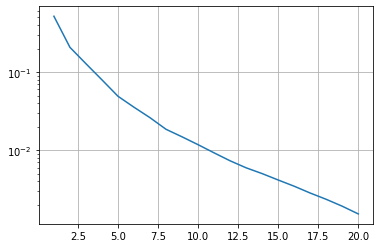

In [64]:
exvar = 1-np.cumsum(fitter.explained_variance_ratio_)
plt.semilogy(np.arange(1,num_components+1),exvar)
plt.grid()

In [65]:
print(exvar)

[0.51757654 0.20735591 0.12794704 0.07958906 0.04909638 0.03554249
 0.02612    0.01856192 0.01487457 0.01180351 0.00927927 0.00734284
 0.00597492 0.00503888 0.00417433 0.00347548 0.00284332 0.00236374
 0.00192923 0.00153825]


Text(0.5, 1.0, '   temp                          dens                        rotation                       itemp                         idens   ')

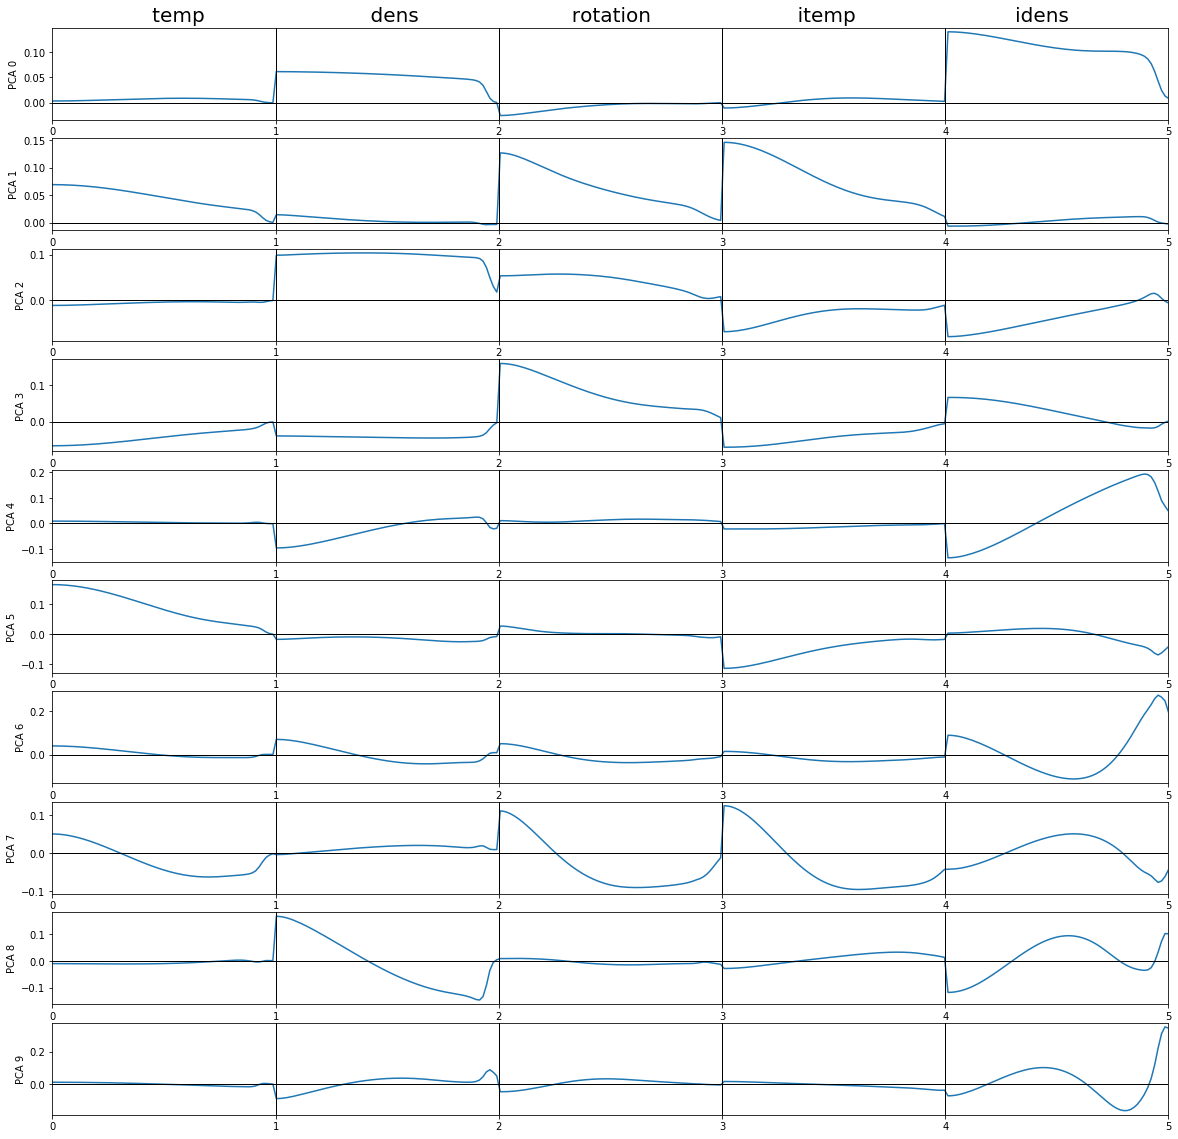

In [67]:
nmodes=10
fig, ax = plt.subplots(nmodes,1,figsize=(20,2*nmodes))
psi = np.linspace(0,len(profiles),X.shape[-1])
for i in range(nmodes):
    ax[i].plot(psi,fitter.components_[i,:])
    ax[i].set_ylabel('PCA {}'.format(i))
    ax[i].axhline(0,color='k',linewidth=1)
    ax[i].set_xlim((0,len(profiles)))
    for j in range(1,len(profiles)):
        ax[i].axvline(j,color='k',linewidth=1)
ax[0].set_title('                    '.join([profile.center(10) for profile in profiles]),size=20)


In [74]:
N = 40 # parameters
M = 150 # measurements
A = np.random.random((M,N))
b = np.random.random(M)


In [75]:
%%timeit
x = np.linalg.lstsq(A,b)

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


806 µs ± 87.5 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'wb+') as f:
#     pickle.dump(full_pca_fitter,f)
# with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'wb+') as f:
#     pickle.dump(kernels,f)

with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')

In [50]:
kernels['temp']['variance']

array([4.11242985e-02, 5.71169228e-03, 2.47462692e-03, 9.47234419e-04,
       4.93366018e-04, 2.43511649e-04, 9.74272177e-05, 4.16170028e-05,
       9.13944222e-06, 2.92965849e-06])

Text(0.5, 0.98, 'Shot: 167472 Time: 1750 ms')

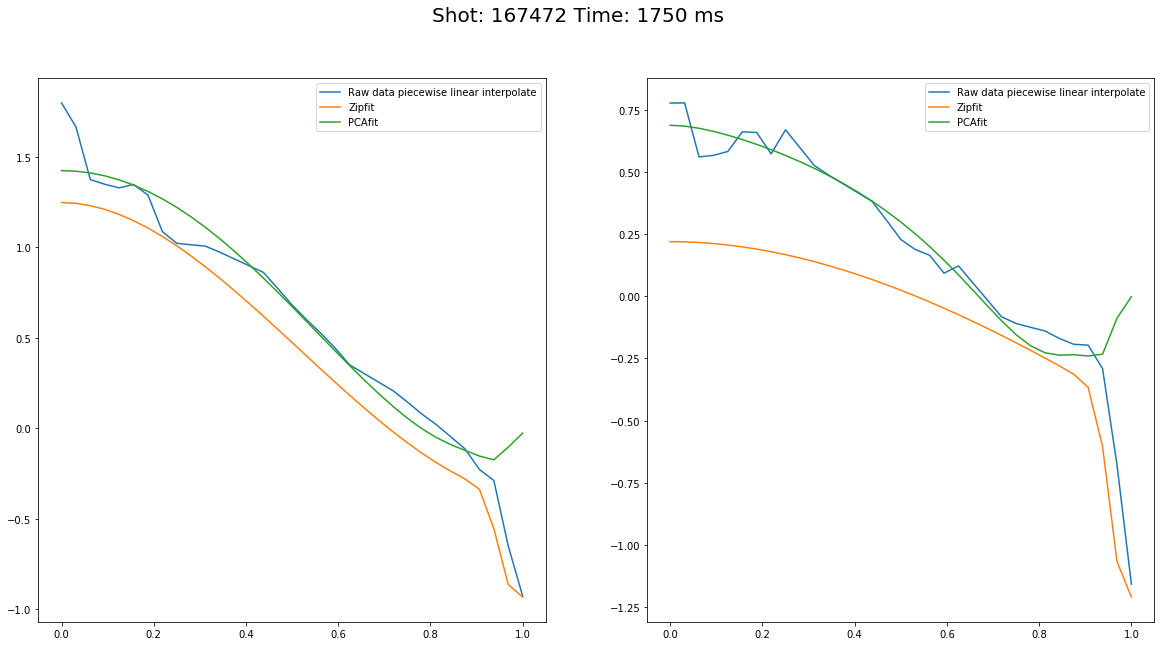

In [55]:
idx = np.random.randint(traindata['temp'].shape[0])
psi = np.linspace(0,1,33)

shotnum = int(traindata['shotnum'][idx][0])
time = int(traindata['time'][idx][0])

temp_zipfit = traindata['temp'][idx,0,::2]
temp_raw = traindata['thomson_temp_EFITRT1'][idx,0,::2]
temp_pcafit = np.dot(temp_raw,kernels['temp'][3])

dens_zipfit = traindata['dens'][idx,0,::2]
dens_raw = traindata['thomson_dens_EFITRT1'][idx,0,::2]
dens_pcafit = np.dot(dens_raw,kernels['dens'][3])


fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(psi,temp_raw, label='Raw data piecewise linear interpolate')
ax[0].plot(psi,temp_zipfit, label='Zipfit')
ax[0].plot(psi,temp_pcafit, label='PCAfit')
ax[0].legend()

ax[1].plot(psi,dens_raw, label='Raw data piecewise linear interpolate')
ax[1].plot(psi,dens_zipfit, label='Zipfit')
ax[1].plot(psi,dens_pcafit, label='PCAfit')
ax[1].legend()

fig.suptitle('Shot: {} Time: {} ms'.format(shotnum,time),size=20)
